In [ ]:
# Make code toggle-able for easier review.
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></i>.''')

In [ ]:
# Import basic data processing libraries
import numpy as np
import pandas as pd

# Import data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import seaborn as sns

# Import text processing libraries
from nltk.corpus import stopwords
import re

# Import modeling libraries
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Import model validation libraries
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics

# Import a couple of quality-of-life tools
from itertools import cycle
from collections import Counter

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<a name='toc'></a>
# Predicting Project Success in Kickstarter Campaigns
<a href='#introduction'>Introduction</a> • 
<a href='#cleaning'>Data Cleaning</a> • 
<a href='#overview'>Overview of Variables</a> • 
<a href='#features'>Feature Engineering</a> • 
<a href='#models'>Feature Selection & Modeling</a> •
<a href='#conclusion'>Conclusion & Next Steps</a>

In [ ]:
# Get the data
filepath = '/Users/guest/Dropbox/Education/Thinkful/Unit 3 - Deeper into supervised learning/Unit 3 Capstone/kickstarter-projects/ks-projects-201801.csv'
df = pd.read_csv(filepath)

In [ ]:
# Control overall figure aesthetics

sns.set(context = 'notebook',
        font='Arial',
        style='white')

# Define consistent colors for each CATEGORY
cycol = cycle(sns.color_palette("Accent", 15).as_hex())
cat_col_idx = {}

for main_category in df['main_category'].value_counts().index:
        cat_col_idx[main_category] = next(cycol)
        
        
# Define consistent colors for each CURRENCY
cycol = cycle(sns.color_palette("Accent", 14).as_hex())
curr_col_idx = {}

for currency in df['currency'].value_counts().index:
        curr_col_idx[currency] = next(cycol)

<br><br>

# <a name='introduction'></a>Introduction

####  This dataset contains a summary of every Kickstarter project created between the site's April 2009 launch and January 2, 2018 __(n = 378,66)__
Mickaël Mouillé (https://www.kaggle.com/kemical) scraped it directly from Kickstarter.com on 01/02/2018 and hosted it on Kaggle (https://www.kaggle.com/kemical/kickstarter-projects/home), where I accessed it on 7/24/18.

In [ ]:
%%html # Allows for easier reading with the table below
<style> 
table {float:left}
</style>

####  The following data is provided for each project:


* __ID:__ Internal kickstarter ID number
* __name:__ Name of Kickstarter project, as defined by its creator.
* __main_category:__ Overall category of the project.
* __category:__ Subcategory within main category of the project.
* __currency:__ National currency that the project collected.
* __deadline:__ Fundraising deadline for the project.
* __goal:__ Fundraising goal for the project.
* __launched:__ Start date for the project.
* __pledged:__ Funding received from backers.
* __state:__ Current state of project (failed, successful, canceled, live, undefined, or suspended).
* __backers:__ Number of individual backers.
* __usd pledged:__ Pledges received in USD, regardless of project currency. Conversion done by Kickstarter.
* __usd_pledged_real:__ Pledges received in USD, regardless of project currency. Conversion from Fixer.io API.
* __usd_goal_real:__ Funding goal in USD. Conversion from Fixer.io API.

In [ ]:
df.head(n=1)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95


__NOTE:__ _US Dollar amounts were able to be scraped directly from Kickstarter for 'pledged' amounts, but not for 'goal' amounts. For consistency's sake between the two columns, I exclusively use the conversions from the Fixer.io API throughout my analysis._

<hr>
[<a href='#toc'><i>return to top</i></a>]<br><br><br><br><br><br>

# <a name='cleaning'></a>Data Cleaning

#### There are 3,801 observations that are missing data with regard to project state, backers, country, and/or pledges. I spot-checked these observations to their corresponding projects listed on Kickstarter, and the problem appears to be with the scraper, not any kind of unusual state for the project itself.

#### However, because the scraper still calculated real dollar amounts & scraped currency, I feel comfortable that I can impute a lot of the missing data with a high degree of accuracy.

In [ ]:
print('There are {} rows with missing data'.format(df[pd.isnull(df).any(axis=1)].shape[0]))
df[pd.isnull(df).any(axis=1)].head(n=2)

There are 3801 rows with missing data


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.0,undefined,0,"N,0""",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.0,undefined,0,"N,0""",NaN,3402.08,3211.53


##### Project State <i>(nulls in the raw data are coded as 'undefined')</i>
1. If a project's deadline is after 01/02/18, I can code state as 'live.'
2. If a project's <i>'usd_pledged_real'</i> exceeds or matches its <i>'usd_goal_real'</i>, I can code state as 'successful'.
3. If a project's <i>'usd_goal_real'</i> exceeds its <i>'usd_pledged_real'</i>, I can code state as 'failed'.

In [ ]:
# Account for projects that were live when the data was scraped
df['state_cln'] = np.where((df['state'] == 'undefined') & ((df['deadline'] > '2018-01-02')), 'live', df['state'])

# Account for failed and successful projects
df['state_cln'] = np.where((df['state_cln'] == 'undefined') & ((df['usd_pledged_real'] >= df['usd_goal_real'])), 'successful', df['state_cln'])
df['state_cln'] = np.where((df['state_cln'] == 'undefined') & ((df['usd_pledged_real'] < df['usd_goal_real'])), 'failed', df['state_cln'])

print('There are {} undefined states in the raw data.'.format(df[df['state'] == 'undefined'].shape[0]))
print('There are {} undefined states in the cleaned data.'.format(df[df['state_cln'] == 'undefined'].shape[0]))

There are 3562 undefined states in the raw data.
There are 0 undefined states in the cleaned data.


##### Country <i>(nulls in the raw data are coded as 'N,0')</i>
* I can impute <i>'country'</i> directly from <i>'currency'</i>. This not is likely to be 100% accurate, as the correlation between a project's currency and being based in that currency's country of origin is probably not _exactly_ one. 
* This method also won't work for Eurozone countries. However, I'll be using this method on ~1% of observations, and I expect it to work reasonably well, so I'm not too worried about it skewing my data.

In [ ]:
df['country_cln'] = np.where(df['country'] == 'N,0"', df['currency'].apply(lambda x: x[0:2]), df['country'])
df['country_cln'] = np.where(df['country_cln'] == 'EU', 'EU_undefined', df['country_cln'])

print('There are {} null countries in the raw data.'.format(df[df['country'] == 'N,0"'].shape[0]))
print('There are {} null countries in the cleaned data.'.format(df[df['country_cln'] == 'N,0"'].shape[0]))
print('There are {} undefined Eurozone countries in the cleaned data.'.format(df[df['country_cln'] == 'EU_undefined'].shape[0]))

There are 3797 null countries in the raw data.
There are 0 null countries in the cleaned data.
There are 186 undefined Eurozone countries in the cleaned data.


##### Backers <i>(nulls in the raw data occur are coded as 0, but have a pledged amount of > 0)</i>
* I'll simply use the median to impute for <i>'backers'</i>. I could deploy a regressor of some kind to shoot for more accuracy, but I feel that that would be an impractical use of time given the small number of missing values.

In [ ]:
df['backers_cln'] = np.where((df['backers'] == 0) & (df['usd_pledged_real'] > 0 ), df['backers'].median(), df['backers'])

raw_bckr_null = df[(df['backers'] == 0) & (df['usd_pledged_real'] > 0 )].shape[0]
cln_bckr_null = df[(df['backers_cln'] == 0) & (df['usd_pledged_real'] > 0 )].shape[0]

print('There are {} null values for backers in the raw data.'.format(raw_bckr_null))
print('There are {} null values for backers in the cleaned data.'.format(cln_bckr_null))

There are 3082 null values for backers in the raw data.
There are 0 null values for backers in the cleaned data.


##### USD Pledged <i>(nulls in the raw data are coded as NaN)</i>
* This column is redundant with <i>'usd_pledged_real'</i>, and I didn't plan to use it anyway. I can just drop it.

In [ ]:
df.drop(labels='usd pledged', axis=1, inplace=True)
print(list(df))

['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd_pledged_real', 'usd_goal_real', 'state_cln', 'country_cln', 'backers_cln']


##### Name <i>(nulls in the raw data are coded as NaN)</i>
* Short of re-scraping the data, there's nothing I can do about the missing names. I plan to engineer features based on title words, but I expect the impact of the missing data to be minimal. For now, I'm going to deal with them by replacing the NaNs with empty strings.

In [ ]:
print('There are {} missing names in the raw data.'.format(df[df['name'].isnull() == True].shape[0]))
df['name'] = np.where(df['name'].isnull() == True, '', df['name'])
print('There are {} missing names in the cleaned data.'.format(df[df['name'].isnull() == True].shape[0]))

There are 4 missing names in the raw data.
There are 0 missing names in the cleaned data.


##### Date <i>(problem dates in the raw data are coded as 01/01/1970)</i>
* There are 7 projects that incorrectly list 01/01/1970 as their launch date. All of these projects are canceled or suspended, and I suspect that they're coded in this way because of a problem with the scraper. I'm going to drop these 7 records from my analysis.

In [ ]:
print('There are {} incorrectly coded launch dates in the data.'.format(df[df['launched'] == '1970-01-01 01:00:00'].shape[0]))
df.drop(df[df['launched'] == '1970-01-01 01:00:00'].index, inplace=True)
print('There are {} incorrectly coded launch dates in the data.'.format(df[df['launched'] == '1970-01-01 01:00:00'].shape[0]))

There are 7 incorrectly coded launch dates in the data.
There are 0 incorrectly coded launch dates in the data.


* I'm also going to go ahead and convert the string-formatted dates to datetime format.

In [ ]:
df['launched_cln'] = pd.to_datetime(df['launched'], format='%Y-%m-%d')
df['deadline_cln'] = pd.to_datetime(df['deadline'], format='%Y-%m-%d')

##### Data cleaning is done!

In [ ]:
print('There are {} rows with missing data'.format(df[pd.isnull(df).any(axis=1)].shape[0]))

There are 0 rows with missing data


<hr>
[<a href='#toc'><i>return to top</i></a>]<br><br><br><br><br><br>

# <a name='overview'></a>Overview of Variables
#### Project state (<i>'state'</i>) describes a project's status as successful, failed, canceled (by their creator), live, or suspended (by Kickstarter). The majority of projects (~63%) fail or are canceled by their creators.


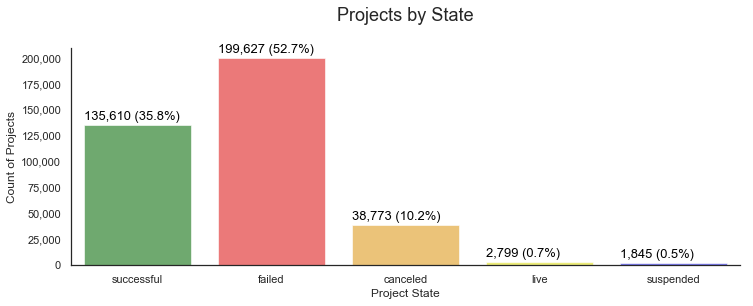

In [ ]:
# Define a function I can use to plot data labels
def plot_cat_labels(variable, dataframe, label_order, axis='x', fontsize=13):
    for i, v in enumerate(label_order):
        v_count = dataframe[dataframe[variable] == v].shape[0]
        v_percent = round(v_count / dataframe.shape[0] * 100,1)

        if axis=='x':
            v_label = "{:,.0f} ({}%)".format(v_count,v_percent)
            ax.text(i-.4, 
                    v_count + dataframe[variable].value_counts()[0]/40, 
                    v_label, 
                    color='black',
                    weight='ultralight',
                    multialignment='center',
                    fontsize=fontsize)
        else:
            v_label = "{:,.0f} ({}%)".format(v_count,v_percent)
            ax.text(v_count + dataframe[variable].value_counts()[0]/200,
                    i + 0.1, 
                    v_label, 
                    color='black',
                    weight='ultralight',
                    multialignment='center',
                    fontsize=fontsize)

# Plot project state
order = ['successful', 'failed', 'canceled', 'live', 'suspended']
plt.figure(figsize=(12,4))
ax = sns.countplot(df['state_cln'],
              order = order,
              palette = ['green', 'red', 'orange', 'yellow', 'blue'], alpha=0.6)

plt.title('Projects by State\n', fontsize=18)
plt.ylabel('Count of Projects')
plt.xlabel('Project State')

# Plot category labels
plot_cat_labels('state_cln', df, order)

# Set aesthetics and show the plot
ax.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.despine()
plt.show()

<br><br>
#### Overall categories (column <i>'main_category'</i>) are broad thematic groupings of projects, defined by Kickstarter and classified on the project level by each project's creator.

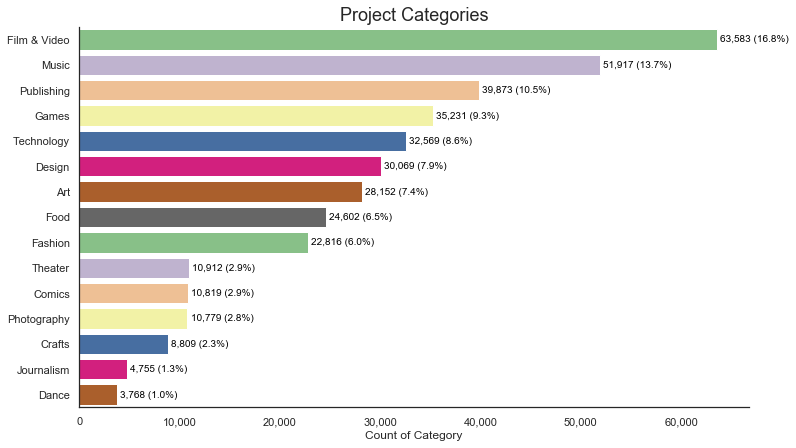

In [ ]:
# Produce a count plot of the main categories
plt.figure(figsize=(12,7))
ax = sns.countplot(y=df['main_category'], 
              order=df['main_category'].value_counts().index,
              palette=list(cat_col_idx.values()),
             alpha=1)

plt.title('Project Categories', fontsize=18)
plt.ylabel('')
plt.xlabel('Count of Category')

# Plot data labels
plot_cat_labels('main_category', df, df['main_category'].value_counts().index, fontsize=10, axis='y')
    
# Tweak aesthetics and show the plot
sns.despine()
ax.get_xaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

<br><br>
#### Each category is subdivided into a series of subcategories (column: <i>'category'</i>) that describe genre. These subcategories are also defined by Kickstarter and classified at the project level by each project's creator. For example, the category 'Film & Video' includes the subcategories 'Shorts,' 'Documentary,' 'Comedy,' etc.
To delve more deeply into the breakdown of a specific subcategory, feel free to edit the string at the bottom of the cell below.

In [ ]:
# Define a function that plots categories and their corresponding subcategories.
def category_summary(main_category):    
    # Get an overall count for the category
    main_category_count = df[df['main_category'] == main_category].shape[0]  

    # Build a dataframe that summarizes subcategories as percentages of categories
    subcat_summaries = {'percent_of_category':[]} 
    subcat_summaries['subcategory'] = list(df['category'][df['main_category'] == main_category].unique())
    for subcat in list(df['category'][df['main_category'] == main_category].unique()):
        subcat_count = df['category'][(df['main_category'] == main_category) & (df['category'] == subcat)].shape[0]
        subcat_summaries['percent_of_category'].append(subcat_count/main_category_count)
    subcategories_frame = pd.DataFrame(subcat_summaries)        
 
    # Plot the figure for the category
    plt.figure(figsize=(12,5))

    # Plot the overall category
    ax1 = plt.subplot(211)
    sns.countplot(y=df['main_category'][df['main_category'] == main_category],
                  color=cat_col_idx[main_category], 
                  alpha=0.9) 
    sns.despine()
    title = main_category + ' and its subcategorical makeup\nn = {}; '.format(main_category_count) + str(round(((main_category_count/df.shape[0])*100),1)) + '% of total projects'
    plt.title(title, fontsize = 18)
    ax1.set_xlim(0, 65000)
    ax1.set_yticklabels([''])
    plt.xlabel('')
    plt.ylabel('')
    ax1.get_xaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

    # Plot the subcategories within the category
    ax2 = plt.subplot(212)
    sns.barplot(x=subcategories_frame['subcategory'],
                y=subcategories_frame['percent_of_category'],
                color=cat_col_idx[main_category],
                order=df['category'][df['main_category'] == main_category].value_counts().index,
                alpha=0.5)
    sns.despine(trim=True, left=False)
    plt.xlabel('')
    plt.xticks(rotation='vertical')
    plt.ylabel('')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    
    
    ax2.grid(color='grey', linestyle=':', 
             linewidth=1, axis='both', alpha=0.8)

    
    plt.tight_layout()

    plt.show()

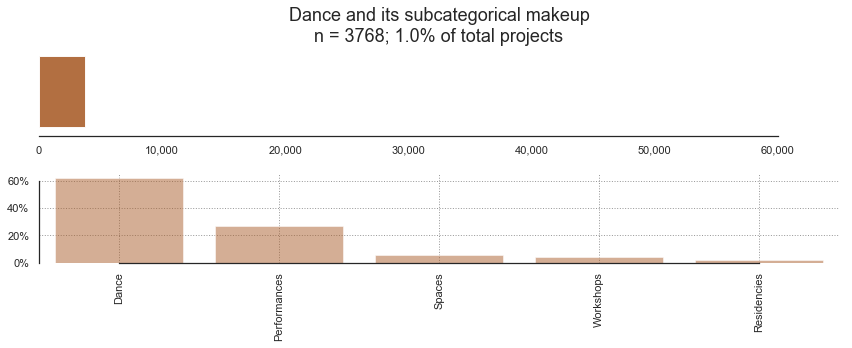

In [ ]:
# Change the string below to view the subcategorical makeup of a different category.
category_summary('Dance') 

<br><br>
#### The _'currencies'_ column describes the national currency raised by a given project.
Projects on Kickstarter have raised funds in 14 different currencies, but the vast majority of projects  have been raised in either __USD (78.0%)__, __GBP (9.0%)__, __EUR (4.6%)__, __CAD (3.95%)__, or __AUD (2.10%)__.

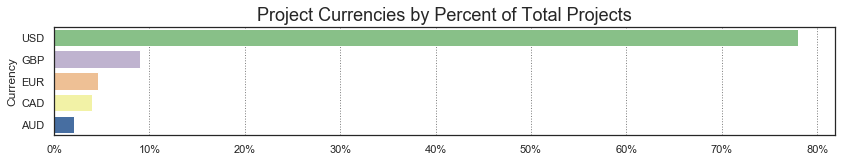

The following currencies each constituted less than 1% of all projects, and are not reproduced on the plot:
 ['SEK', 'MXN', 'NZD', 'DKK', 'CHF', 'NOK', 'HKD', 'SGD', 'JPY']


In [ ]:
currency_breakdown=pd.DataFrame()
currency_breakdown['count'] = df['currency'].value_counts()
currency_breakdown['percent_of_projects'] = currency_breakdown['count'] / currency_breakdown['count'].sum()

# Produce a countplot of the currencies
plt.figure(figsize=(14,2))
ax = sns.barplot(y=currency_breakdown.index[currency_breakdown['percent_of_projects'] > 0.01],
                 x=currency_breakdown['percent_of_projects'][currency_breakdown['percent_of_projects'] > 0.01],
                 order=currency_breakdown.index[currency_breakdown['percent_of_projects'] > 0.01],
                 palette=list(curr_col_idx.values()),
                 alpha=1)

plt.title('Project Currencies by Percent of Total Projects', fontsize=18)
plt.ylabel('Currency')
plt.xlabel('')

# Define aesthetics and show the plot
ax.grid(color='grey', linestyle=':', linewidth=1, axis='x')
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])
plt.show()

# List the excluded currencies.
print('The following currencies each constituted less than 1% of all projects, and are not reproduced on the plot:\n {}'
      .format(str(list(currency_breakdown.index[currency_breakdown['percent_of_projects'] <= 0.01]))))

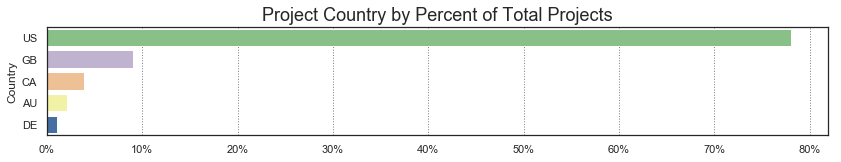

The following countries each constituted less than 1% of all projects, and are not reproduced on the plot:
 ['FR', 'IT', 'NL', 'ES', 'SE', 'MX', 'NZ', 'DK', 'IE', 'CH', 'NO', 'HK', 'BE', 'AT', 'SG', 'EU_undefined', 'LU', 'JP']


In [ ]:
country_breakdown=pd.DataFrame()
country_breakdown['count'] = df['country_cln'].value_counts()
country_breakdown['percent_of_projects'] = country_breakdown['count'] / country_breakdown['count'].sum()

# Produce a countplot of the currencies
plt.figure(figsize=(14,2))
ax = sns.barplot(y=country_breakdown.index[country_breakdown['percent_of_projects'] > 0.01],
                 x=country_breakdown['percent_of_projects'][country_breakdown['percent_of_projects'] > 0.01],
                 order=country_breakdown.index[country_breakdown['percent_of_projects'] > 0.01],
                 palette=list(curr_col_idx.values()),
                 alpha=1)

plt.title('Project Country by Percent of Total Projects', fontsize=18)
plt.ylabel('Country')
plt.xlabel('')

ax.grid(color='grey', linestyle=':', linewidth=1, axis='x')
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])

plt.show()

print('The following countries each constituted less than 1% of all projects, and are not reproduced on the plot:\n {}'
      .format(str(list(country_breakdown.index[country_breakdown['percent_of_projects'] <= 0.01]))))

<br><br>
#### Outliers are a huge part of the story for funding goals (<i>'usd_goal_real'</i>), actual pledges (<i>'usd_pledged_real'</i>), and number of backers (<i>'backers'</i>).

The median dollar value for actual pledges is __\$624.33__ (compare to a mean of _\$9,058.92_), and the median dollar value for project goals is __\$5,500.00__ (compare to a mean of _\$45,454.40_). Both distributions are heavily skewed by the presence of extreme outliers. 
* There is no correlation between funding goal amount and actual pledge amount (r = 0.01).
* 276 projects (0.07%) received more than \$1M in pledges, most notably the Pebble Smartwatch, which raised over \$20M.
* 52,527 projects (13.9%) received no funding whatsoever.

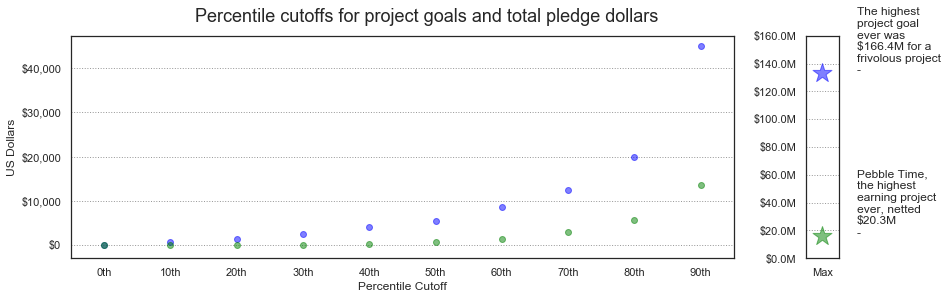

,name,category,main_category,currency,launched,backers_cln,usd_pledged_real,state
157270,"Pebble Time - Awesome Smartwatch, No Compromises",Product Design,Design,USD,2015-02-24 15:44:42,78471.0,20338986.27,successful


In [ ]:
# Aggregate percentiles
percentiles = pd.DataFrame(df[['usd_goal_real','usd_pledged_real','backers_cln']].describe(percentiles=np.arange(0,1,.1))[4:14])
percentiles['percentile'] = np.arange(0,1,0.1)

# Plot the 0th through 90th percentiles.
plt.figure(figsize=(12,4))
ax1 = plt.subplot2grid((1, 8), (0, 0), colspan=7)
plt.scatter(percentiles['percentile'],
            percentiles['usd_goal_real'], 
            color='blue',
            alpha=0.5)
plt.scatter(percentiles['percentile'],
            percentiles['usd_pledged_real'], 
            color='green',
            alpha=0.5)

ax1.grid(color='grey', linestyle=':', linewidth=1, which='both', axis='y', alpha=0.8)

plt.xticks(np.arange(0,1,0.1))
plt.xlabel('Percentile Cutoff')
plt.gca().set_xticklabels(['{:}th'.format(int(x*100)) for x in plt.gca().get_xticks()]) 
plt.ylabel('US Dollars')
plt.gca().get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))

# Plot the max values on a separate scale so they don't edge everything else out.
ax2 = plt.subplot2grid((1, 8), (0, 7), colspan=1)
plt.scatter(1, df['usd_goal_real'].max(),
            color='blue', alpha=0.5,
            s=400, marker='*')
plt.scatter(1, df['usd_pledged_real'].max(),
            color='green', alpha=0.5,
            s=400, marker='*')


ax2.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)

plt.xticks([1],['Max'])
plt.gca().set_yticklabels(['${:}M'.format(x/1000000) for x in plt.gca().get_yticks()]) 
ax2.set_ylim(0, 200000000)

# Annotate the max values for clarity's sake
plt.text(1.3, df['usd_goal_real'].max(), 'The highest\nproject goal\never was\n$166.4M for a\nfrivolous project\n-', fontsize=12)
plt.text(1.3, df['usd_pledged_real'].max(), 'Pebble Time,\nthe highest\nearning project\never, netted\n$20.3M\n-', fontsize=12)

# Label and show the plot
plt.suptitle('Percentile cutoffs for project goals and total pledge dollars', fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

# Show the outlier for pledges
df[['name', 'category', 'main_category', 'currency', 
    'launched', 'backers_cln', 'usd_pledged_real', 'state']][df['usd_pledged_real'] == df['usd_pledged_real'].max()]

<br><br>
#### The distribution of number of backers (<i>'backers'</i>) is defined by tremendous positive skew and extreme outliers on the positive end – essentially similar to the distributions for project goals and total pledges.

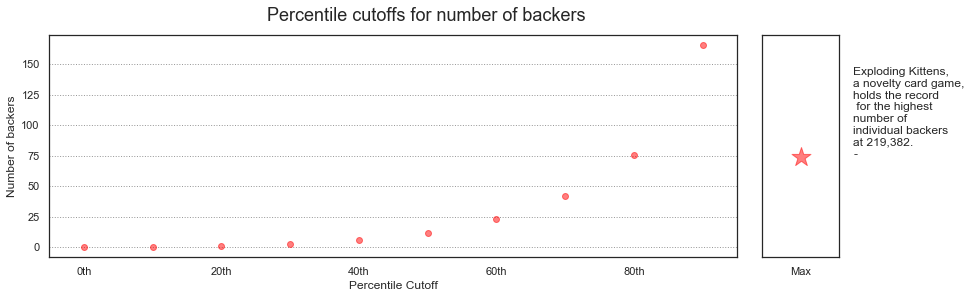

,name,category,main_category,currency,launched,backers_cln,usd_pledged_real,state
187652,Exploding Kittens,Tabletop Games,Games,USD,2015-01-20 19:00:19,219382.0,8782571.99,successful


In [ ]:
plt.figure(figsize=(12,4))

# Plot the 0th through 90th percentiles.
ax1 = plt.subplot2grid((1, 8), (0, 0), colspan=7)
plt.scatter(percentiles['percentile'],
            percentiles['backers_cln'], 
            color='red',
            alpha=0.5)
plt.xlabel('Percentile Cutoff')
plt.gca().set_xticklabels(['{:}th'.format(int(x*100)) for x in plt.gca().get_xticks()]) 
plt.ylabel('Number of backers')

ax1.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)


# Plot the max value on a separate scale so it doesn't edge everything else out.
ax2 = plt.subplot2grid((1, 8), (0, 7), colspan=1)
plt.scatter(1, df['backers_cln'].max(),
            color='red', alpha=0.5,
            s=400, marker='*')
plt.yticks([],[])
plt.text(1.2, df['backers_cln'].max(),'Exploding Kittens,\na novelty card game,\nholds the record\n for the highest\nnumber of\nindividual backers \nat 219,382.\n-', fontsize=12)
plt.xticks([1],['Max'])

ax2.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)

# Label and show the plot
plt.suptitle('Percentile cutoffs for number of backers', fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

# Show the outlier
df[['name', 'category', 'main_category', 'currency', 
    'launched', 'backers_cln', 'usd_pledged_real', 'state']][df['backers'] == df['backers'].max()]

<hr>
[<a href='#toc'><i>return to top</i></a>]<br><br><br><br><br><br>
# <a name='features'></a>Feature Engineering

<a href='#success'>Project Success</a> • 
<a href='#keywords'>In-Name Keywords</a> • 
<a href='#dates'>Year & Month</a> • 
<a href='#duration'>Project Duration</a> • 
<a href='#pledgesize'>Average Pledge Size</a> • 
<a href='#goal_feat'>Project Goal</a> • 
<a href='#cat_feat'>Project Category</a> • 
<a href='#subcat_feat'>Project Sub-Category</a> • 
<a href='#currency_feat'>Currency</a> • 

### [<a name='success'>PROJECT SUCCESS</a>] My outcome of interest is project success. I'll be drawing it from <i>'state_cln'</i>. Because I'm only interested in success, I'll have to drop live campaigns that haven't already met their funding goal from my data altogether – those projects that haven't already met their funding goal may yet do so. I can lump 'failed, 'canceled,' and 'suspended' projects together as unsuccessful.

In [ ]:
df['success'] = np.where(df['state_cln'] == 'successful',1,0)
df['success'] = np.where((df['state_cln'] == 'live') & (df['usd_pledged_real'] > df['usd_goal_real']), 1, df['success'])
df.drop(df[(df['state_cln'] == 'live') & (df['success'] == 0)].index, inplace=True)

print(df['state_cln'][df['success'] == 1].value_counts())
print()
print(df['state_cln'][df['success'] == 0].value_counts())

successful    135610
live             429
Name: state_cln, dtype: int64

failed       199627
canceled      38773
suspended      1845
Name: state_cln, dtype: int64


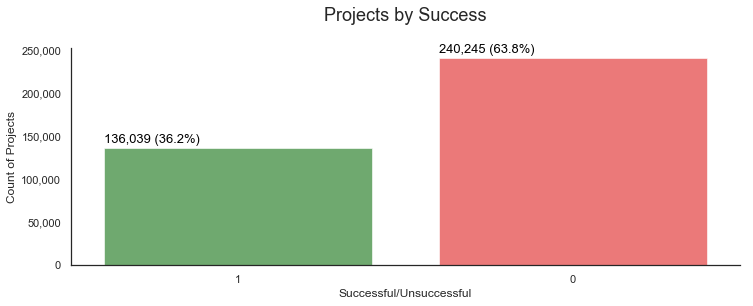

In [ ]:
plt.figure(figsize=(12,4))
ax = sns.countplot(df['success'],
              order = [1, 0],
              palette = ['green', 'red'], alpha=0.6)

plt.title('Projects by Success\n', fontsize=18)
plt.ylabel('Count of Projects')
plt.xlabel('Successful/Unsuccessful')

plot_cat_labels('success',
                df,
                [1, 0])

ax.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))


sns.despine()
plt.show()

<br><br>
### [<a name='keywords'>IN-NAME KEYWORDS</a>] I'm interested in whether some keywords are overrepresented in the names of successful projects relative to unsuccessful ones & vice-versa. If a word is both common and disproportionately represented in failed or successful projects, its presence or absence in a project's name may be worth including as a feature.

#### First, I'll clean the project names, extract keywords, and summarize data about their success & failure counts in a dataframe.

In [ ]:
# Clean the names by stripping away unnecessary characters & standardizing capitalization
df['name_cln'] = df['name'].apply(lambda x: re.sub('-',' ', str(x))) # separate hyphenated words
df['name_cln'] = df['name'].apply(lambda x: re.sub('/',' ', str(x))) # separate words divided by slashes
df['name_cln'] = df['name_cln'].apply(lambda x: re.sub('[^\w\s\d]','', str(x))) # strip non-alphanumeric characters
df['name_cln'] = df['name_cln'].str.lower() # convert all to lowercase

# Create a list of all unique words in project names
all_words = []
for project_name in df['name_cln']: [all_words.append(word) for word in project_name.split()]
all_words = set(all_words)

# Retrieve counts of each word for positive reviews
succ_words = []
for project_name in df['name_cln'][df['success'] == 1]: [succ_words.append(word) for word in project_name.split()]
succ_words = Counter(succ_words)

# Retrieve counts of each word for negative reviews
unsucc_words = []
for project_name in df['name_cln'][df['success'] == 0]: [unsucc_words.append(word) for word in project_name.split()]        
unsucc_words = Counter(unsucc_words)

# Filter out stop words
stop_words = set([re.sub('[^\w\s\d]','', str(x)) for x in stopwords.words('english')])
for word in stop_words:
    succ_words.pop(word, None)
    unsucc_words.pop(word, None)
    somelist = [i for i in filter(lambda i : i not in stop_words, all_words)]
    
# Add zeroes for words not included in each dictionary
for word in (all_words - set(succ_words.keys())): succ_words[word] = 0
for word in (all_words - set(unsucc_words.keys())): unsucc_words[word] = 0
    
# create a dataframe containing counts of each word in both positive and negative reviews
words = pd.DataFrame(list(all_words), columns=['word'])
words['unsucc_ct'] = words['word'].apply(lambda x: unsucc_words[x]) # Count unsuccessful projects
words['succ_ct'] = words['word'].apply(lambda x: succ_words[x]) # Count successful projects
words['total_ct'] = words['unsucc_ct'] + words['succ_ct'] # Count total projects
words['p_succ'] = round(words['succ_ct'] / words ['total_ct'],2) # Retrieve successful proportion of projects

words[words['total_ct'] > 3000].head(n=3)

,word,unsucc_ct,succ_ct,total_ct,p_succ
1129,help,3901,2602,6503,0.40
3432,album,5818,8237,14055,0.59
19892,world,3110,1353,4463,0.30


#### The plot below includes all keywords that occur in more than 1,000 distinct projects and ranks success by the proportion of projects including that keyword that succeeded. Keywords that appeared in successful projects an unusually large or small percentage of the time (+/- 10% as compared to the mean) are labeled. 

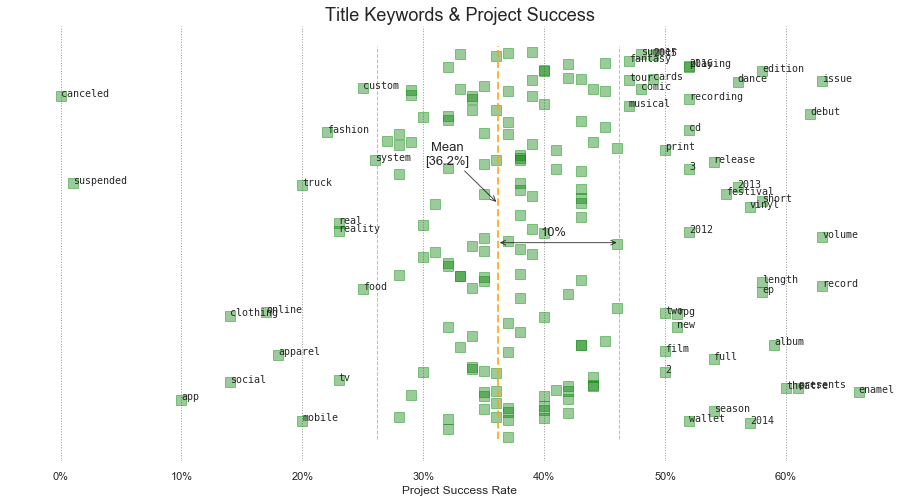

In [ ]:
# Define the outcome mean for use in this & future visualizations
outcome_mean = df['success'].mean()

# Define the cutoff for inclusion in visualizations (1000)
visualization_cut = 1000

# Define the cutoff for inclusion in the features
feature_cut = df.shape[0]/100


# Define a list of keywords for inclusion as features
keywords = []

# Define common (n > 1000) words for a keyword visualization
words_common = words[words['total_ct'] > visualization_cut].copy() # Set the cutoff for 'common'
words_common['jitter'] = np.random.rand(1,words_common.shape[0]).flatten() # Create jitter
ax = plt.axes()

# Plot the common keywords
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.scatter(x=words_common['p_succ'], y=words_common['jitter'], 
            s=100, marker=',', alpha=0.4, color='green')

# Label words with low or high success rates (operationalized as 10% higher or lower than the mean)
for row in words_common.index[(words_common['p_succ'] > outcome_mean + 0.1) | (words_common['p_succ'] < outcome_mean - 0.1)]:
    plt.text(x=words_common.loc[row]['p_succ'], y=words_common.loc[row]['jitter'], 
             s=words_common.loc[row]['word'], rotation=0, fontsize=10, wrap=True, family='monospace')
    

# Plot the mean and a 10% interval
plt.plot([outcome_mean,outcome_mean], [0, 1], color='orange', 
         linestyle='--', linewidth=2, alpha=0.8)
plt.plot([outcome_mean+0.1,outcome_mean+0.1], [0, 1], color='orange', 
         linewidth=1, linestyle='--', alpha=0.8)
plt.plot([outcome_mean-0.1,outcome_mean-0.1], [0, 1], color='orange', 
         linewidth=1, linestyle='--', alpha=0.8)

# Annotate the interval
plt.annotate(s='', xy=(outcome_mean,0.5), xytext=(outcome_mean+0.1,0.5), 
             arrowprops={'arrowstyle':'<->', 'linestyle':'-', 'linewidth':1, 'alpha':0.7, 'color':'black'})
plt.text(x=0.408, y=0.52, ha='center', s='10%', family='arial',  fontsize=13)

plt.annotate(s='Mean\n[36.2%]', xy=(outcome_mean,0.6), 
             xytext=(0.32,0.7), fontsize=13,
             family='arial', ha='center',
             arrowprops={'arrowstyle':'->', 'linestyle':'-', 'linewidth':1, 'alpha':0.7, 'color':'black'})

# Label and show the plot
sns.despine(left=True, bottom=True)
plt.title('Title Keywords & Project Success', fontsize=18)
plt.xlabel('Project Success Rate')
ax.grid(color='grey', linestyle=':', linewidth=1, axis='x', alpha=0.8)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])

ax.axes.get_yaxis().set_visible(False)

plt.show()

* 'Canceled' and 'suspended' appear to be automatically applied to the titles of canceled and suspended projects. They therefore won't be useful for making predictions about projects that haven't finished yet.
* Some keywords are clumped near each other in ways that very clearly suggest correlation – 'reality' and 'tv,' for example.
* Some keywords appear to be extraordinarily toxic, while others appear to perform much better than expected. For example, projects that include 'app' in their name fail 90% of the time, but projects that include 'enamel' in the name perform much better than expected.

#### If you're curious about a particular keyword's performance, feel free to edit the string in the function below.

In [ ]:
# Define a simple function to summarize a keyword's performance
def keyword_check(keyword):
    count_s = words[words['word'] == keyword]['succ_ct'].sum()
    total_n = words[words['word'] == keyword]['total_ct'].sum()
    prob = round((count_s/total_n*100),2)
     
    print("There have been {} projects that included the keyword '{}'".format(total_n,keyword))
    print('{} ({}%) were successful, as compared to the mean success rate of 36.2%'.format(count_s,prob))

keyword_check('app') # Change the string here to look up a keyword's success rate

There have been 3204 projects that included the keyword 'app'
330 (10.3%) were successful, as compared to the mean success rate of 36.2%


#### Adding the features:

In [ ]:
# Define the cutoff for inclusion as a feature (1%)
include_words = words[words['total_ct'] > feature_cut].copy()
keywords = list(include_words[(words_common['p_succ'] > outcome_mean + 0.1) | (words_common['p_succ'] < outcome_mean - 0.1)]['word'])

# Iterate through the rows, coding 1 for projects that contain the keyword in their name & 0 for those that do not.
for word in keywords: df[word] = df['name_cln'].str.contains(word + '\W', case=True, na=0, regex=True).apply(lambda x: int(x))
    
# Create a list of features
feature_list = []

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Although I'll pare down my feature set later, I want to go ahead and rule out features that might cause multicollinearity problems in my model. Every time I add a group of features, I'll pare down the ones that are highly correlated with each other. I'll also remove features that aren't correlated with success later on, but if I catch any now I'll go ahead and take them out.

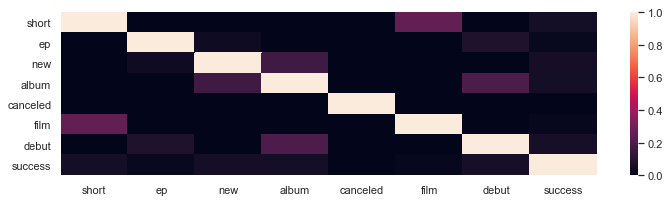

In [ ]:
# Define a function that I'll use to examine multicollinearity
def correlation_heatmap(x_vars):
    plt.figure(figsize=(12,3))
    sns.heatmap(df[x_vars + ['success']].corr(), False, robust=True)
    plt.show()
    
correlation_heatmap(['short', 'ep', 'new', 'album', 'canceled', 'film', 'debut'])

#### These features look fine in terms of multicollinearity, but they're also not correlated with success. I'm going to omit them from my model.

<br><br>
### [<a name='dates'>YEAR & MONTH</a>] I'd like to incorporate month and year as features if appropriate. Project year will only be useful for predicting future projects if there's a meaningful year-to-year trend, but month might provide more useful features if I split it out into dummies. Year and month are provided for two different dates in the raw data – project launch date, and project completion date. I shouldn't draw the same features from both as they're very tightly correlated, so I'll also have to decide which column to extract which data from.

Below are two heatmaps that visualize project success rate across month and year for both launch date and deadline date.

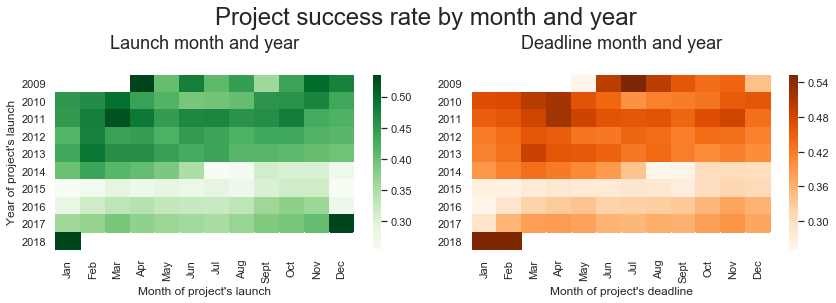

In [ ]:
# Create columns for launch year and launch month
df['lnch_yr'] = df['launched_cln'].dt.year
df['lnch_month'] = df['launched_cln'].dt.month

# Create columns for deadline year and deadline month
df['ddln_yr'] = df['deadline_cln'].dt.year
df['ddln_month'] = df['deadline_cln'].dt.month

# Create a list of month labels
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']

# Plot heatmaps that visualize the relationship between month, year, and project success rate
plt.figure(figsize=(12,4))

ax1 = plt.subplot(121) # Plot the launch heatmap
sns.heatmap(df.pivot_table(index='lnch_yr', columns='lnch_month', values='success'), 
            cmap="Greens", annot=False, fmt='.0%', robust=True, xticklabels=month_labels)
plt.title('Launch month and year\n', fontsize=18)
plt.xlabel("Month of project's launch")
plt.ylabel("Year of project's launch")



ax2 = plt.subplot(122) # Plot the deadline heatmap
sns.heatmap(df.pivot_table(index='ddln_yr', columns='ddln_month', values='success'), 
            cmap="Oranges", annot=False, fmt='.0%', robust=True, xticklabels=month_labels)
plt.title('Deadline month and year\n', fontsize=18)
plt.xlabel("Month of project's deadline")
plt.ylabel('')




# Tweak aesthetics and show the visualization
plt.suptitle('Project success rate by month and year', y=1.05, fontsize=24)
plt.tight_layout()
plt.show()

* The relationship between the two is immediately apparent – they're almost identical plots, but deadline is shifted forward about 30 days. 
* 2014-2016 appear to have been exceptionally bad years for project success, while 2010 and 2011 appear to have been exceptionally good. 
<br>

#### Now let's drill down on the overall trends by plotting mean project success rate across all months.

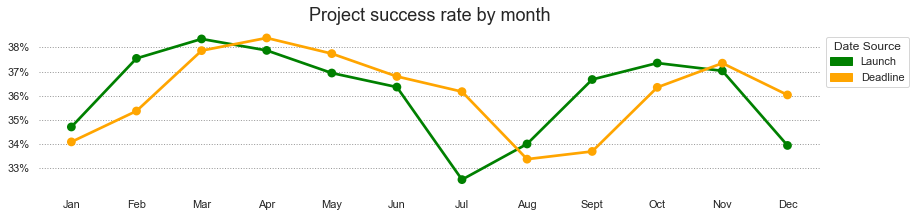

In [ ]:
# Create a legend to help visually differentiate between the two lines
yrmo_legend = [mpatches.Patch(color='green', label='Launch'),
               mpatches.Patch(color='orange', label='Deadline')]

# Plot success rate by month
plt.figure(figsize=(14,3))
ax1 = sns.pointplot(x=df['lnch_month'].unique(),
              y=[df[df['lnch_month'] == month]['success'].mean() for month in df['lnch_month'].unique()], 
              color='green', alpha=0.5)
ax2 = sns.pointplot(x=df['ddln_month'].unique(),
              y=[df[df['ddln_month'] == 
                    month]['success'].mean() for month in df['ddln_month'].unique()],
              color='orange', alpha=0.5)

# Tweak aesthetics
plt.title('Project success rate by month', size=18)
ax1.set_xticklabels(month_labels)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
ax1.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
sns.despine(left=True, bottom=True)

# Plot the legend
plt.legend(handles=yrmo_legend, 
           loc="lower left",
           bbox_to_anchor=(1, .6),
           title='Date Source')

# Show the figure
plt.show()

* It looks like March-April and Oct-Nov are peak-performing months, while July and December are exceptionally poor performers. 
* The 30-day stagger between launch and deadline performance is even more apparent here than in the heatmap – it's clear that we're looking at essentially the same line.

#### The plot below visualizes mean project success rate by year for both launch and deadline date. 2018 is excluded from the visualization, as its very few projects at the time of scraping were disproportionately successful and extended the upper y limit of the plot to 90%, making it difficult to see more nuanced differences between years.

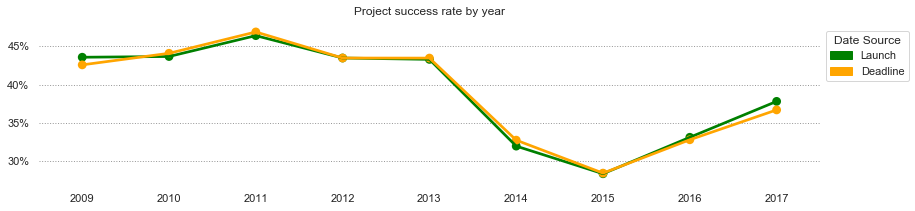

In [ ]:
# Plot success rate by year
plt.figure(figsize=(14,3))
ax1 = sns.pointplot(x=df['lnch_yr'][df['lnch_yr'] != 2018][df['lnch_yr'] != 2018].unique(),
              y=[df[df['lnch_yr'] == year]['success'].mean() for year in df['lnch_yr'][df['lnch_yr'] != 2018].unique()], 
              color='green', alpha=0.5)
ax2 = sns.pointplot(x=df['ddln_yr'][df['ddln_yr'] != 2018].unique(),
              y=[df[df['ddln_yr'] == year]['success'].mean() for year in df['ddln_yr'][df['ddln_yr'] != 2018].unique()], 
              color='orange', alpha=0.5)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.title('Project success rate by year')
sns.despine()

sns.despine(left=True, bottom=True)
ax1.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)

# Plot the legend
plt.legend(handles=yrmo_legend, 
           loc="lower left",
           bbox_to_anchor=(1, .6),
           title='Date Source')

plt.show()

* The year-to-year trends that were apparent in the heatmap are even clearer in this trend line. Projects appeared to get a pretty good bump for the first few years after Kickstarter began operating, followed by a sharp decline from 2014-2015 and a period of growth extending into the present.

#### Adding the features:

In [ ]:
yrmo_features = []

# Create year variables that are appropriate to a regression model
df['lnch_yr_cln'] = df['lnch_yr'] - df['lnch_yr'].min() + 1
yrmo_features.append('lnch_yr_cln')

# Launch Month
yrmo_features.append('lnch_month')

#### All of these are mutually exclusive, so I'm not worried about multicollinearity.

In [ ]:
for variable in yrmo_features: feature_list.append(variable)

<br><br>
### [<a name='duration'>PROJECT DURATION</a>] I expect that the number of days a project runs impacts its probability of success. I can derive project duration from deadline and launch date.

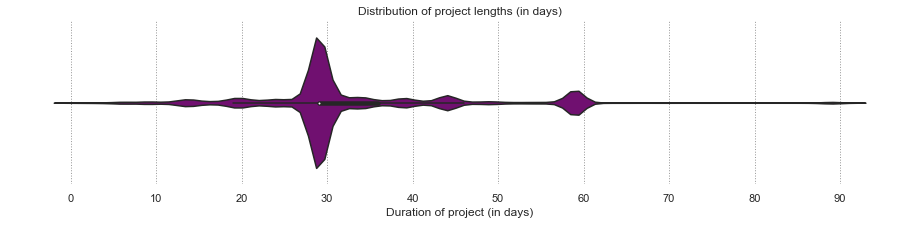

In [ ]:
# Derive duration from the raw data.
df['duration'] = (df['deadline_cln'] - df['launched_cln']).dt.days

# Plot the duration
ax = plt.axes()
fig = plt.gcf()
fig.set_size_inches(16, 3)
sns.violinplot(df['duration'], 
               color='purple')

# Tweak aesthetics and show the plot
plt.title('Distribution of project lengths (in days)')
plt.xticks(np.arange(0,100,10))
ax.grid(color='grey', linestyle=':', linewidth=1, axis='x', alpha=0.8)
plt.xlabel('Duration of project (in days)')
sns.despine(bottom=True, left=True)
plt.show()

* It appears that the vast, vast majority of projects run for a month (28-31 days). There's a pretty strong positive skew here – Kickstarter allows projects to run up to 90 days, but very few actually run that long.


#### Adding the features:

In [ ]:
feature_list.append('duration')

# Summarize the current features
print('Feature list contains: {}'.format(feature_list))

Feature list contains: ['lnch_yr_cln', 'lnch_month', 'duration']


<br><br>
### [<a name='pledgesize'>AVERAGE PLEDGE SIZE</a>] Because I won't have a value for this data until at least one person donates to a campaign, this feature won't be useful for predicting unlaunched campaign outcomes. It's also directly related to dollars pledged, which, in combination with goal dollars, defines my outcome variable. However, I want to try it in my second model because I think it'll offer me valuable insight into what causes campaigns to succeed – is the golden ticket a few large donors, or lots of little ones?

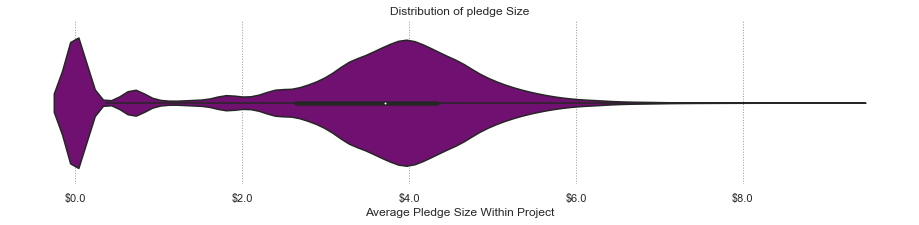

In [ ]:
# Define the variable
df['pledge_size'] = np.where(df['backers'] == 0, 0, df['usd_pledged_real']/df['backers'])
df['pledge_size'] = df['pledge_size'].apply([lambda x: np.log(x + 1)])

# Plot pledge size
ax = plt.axes()
fig = plt.gcf()
fig.set_size_inches(16, 3)
sns.violinplot(df['pledge_size'], 
               color='purple')

# Set aesthetics and show the plot
plt.title('Distribution of pledge Size')
plt.xlabel('Average Pledge Size Within Project')
plt.gca().set_xticklabels(['${:}'.format(x) for x in plt.gca().get_xticks()]) 
ax.grid(color='grey', linestyle=':', linewidth=1, axis='x', alpha=0.8)
sns.despine(bottom=True, left=True)
plt.show()

* There isn't a single campaign with an average pledge size over \$9.00, which indicates that donations tend to skew small.

#### Adding the features:

In [ ]:
feature_list.append('pledge_size')
print('Feature list contains: {}'.format(feature_list))

Feature list contains: ['lnch_yr_cln', 'lnch_month', 'duration', 'pledge_size']


<br><br>
### [<a name='goal_feat'>GOAL</a>] Project goal is the only continuous variable available to me if I'm just taking into account data available before a project's launch. I also have a hunch it's going to be a really critical predictor of success; that projects with astronomical goals probably tend to fail, and projects with very small ones tend to succeed.

* Project goal has some really extreme outliers – I'm going to minimize their impact on my model by incorporating the natural log of goal rather than goal itself as a feature.

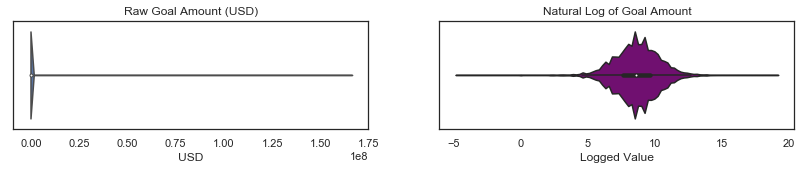

In [ ]:
plt.figure(figsize=(14,2))

ax1 = plt.subplot(121)   
sns.violinplot(df['usd_goal_real'])
plt.title('Raw Goal Amount (USD)')
plt.xlabel('USD')

ax2 = plt.subplot(122)
df['usd_goal_log'] = df['usd_goal_real'].apply([lambda x: np.log(x)])
sns.violinplot(df['usd_goal_log'],
               color='purple')
plt.title('Natural Log of Goal Amount')
plt.xlabel('Logged Value')
plt.show()

#### Adding the features:

In [ ]:
feature_list.append('usd_goal_log')
print('Feature list contains: {}'.format(feature_list))

Feature list contains: ['lnch_yr_cln', 'lnch_month', 'duration', 'pledge_size', 'usd_goal_log']


<br><br>
### [<a name='cat_feat'>CATEGORY</a>] This should be a pretty straightforward conversion – I'm just going to try adding dummies for all of the categories.

In [ ]:
# Add the features
df = pd.concat([df, pd.get_dummies(df['main_category'], prefix='mc', prefix_sep='_')], axis=1)

category_list = []

# Update the feature list
[category_list.append('mc_' + cat) for cat in df['main_category'].unique()]
print(category_list)

['mc_Publishing', 'mc_Film & Video', 'mc_Music', 'mc_Food', 'mc_Design', 'mc_Crafts', 'mc_Games', 'mc_Comics', 'mc_Fashion', 'mc_Theater', 'mc_Art', 'mc_Photography', 'mc_Technology', 'mc_Dance', 'mc_Journalism']


#### Checking correlations

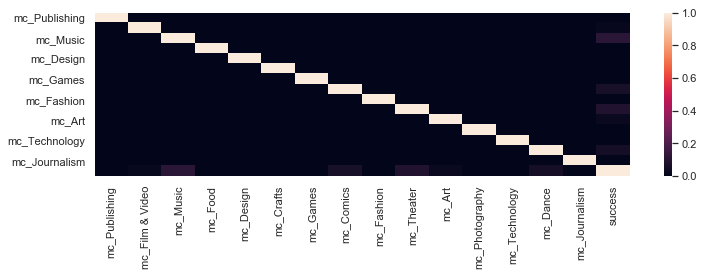

In [ ]:
correlation_heatmap(category_list)

#### Again, there are no problems with multicollinearity (because project categories are mutually exclusive), but also no meaningful correlations.

<br><br>
### [<a name='subcat_feat'>SUB-CATEGORY</a>] I'm going to use the same criteria for potential feature inclusion for sub-categories as I did for in-title keywords: (1) occurs in 1%+ of projects, and (2) is at least 10% different from the overall success rate of 36.2%.

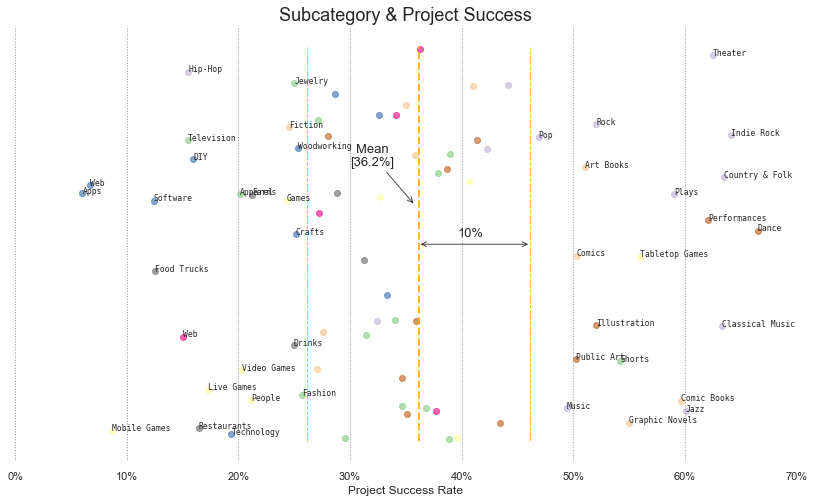

In [ ]:
# Keywords
subcat_kws = []

# Create the figure
ax = plt.axes()
fig = plt.gcf()
fig.set_size_inches(14, 8)

# Plot the points and labels for each subcategory
for main_category in df['main_category'].value_counts().index: # iterate through the main categories
    
    # Create a temporary dataframe for the main category that summarizes the performance of its subcategories
    subcat_succ = df[df['main_category'] == main_category][['category','success']].groupby('category').mean()
    subcat_succ['counts'] = df[df['main_category'] == main_category].groupby('category').count()['ID']
    subcat_succ['jitter'] = np.random.rand(1,subcat_succ.shape[0]).flatten()
    
    # Plot color coded points
    plt.scatter(x=subcat_succ[subcat_succ['counts'] > visualization_cut]['success'], 
                y=subcat_succ[subcat_succ['counts'] > visualization_cut]['jitter'],
                color=cat_col_idx[main_category],
               alpha=0.6)
    
    # Plot text labels
    for row in subcat_succ.index[(subcat_succ['counts'] > visualization_cut) & 
                                 ((subcat_succ['success'] > outcome_mean+0.1) | (subcat_succ['success'] < outcome_mean-0.1))]: 
        subcat_kws.append(row)
        plt.text(x=subcat_succ.loc[row]['success'], y=subcat_succ.loc[row]['jitter'], 
                 s=row, rotation=0, fontsize=8, wrap=True, family='monospace')
    
# Plot the mean and a 10% interval for reference
plt.plot([outcome_mean,outcome_mean], [0, 1], color='orange', 
         linestyle='--', linewidth=2, alpha=0.8)
plt.plot([outcome_mean+0.1,outcome_mean+0.1], [0, 1], color='orange', 
         linewidth=1, linestyle='--', alpha=0.8)
plt.plot([outcome_mean-0.1,outcome_mean-0.1], [0, 1], color='orange', 
         linewidth=1, linestyle='--', alpha=0.8)

# Annotate the interval
plt.annotate(s='', xy=(outcome_mean,0.5), xytext=(outcome_mean+0.1,0.5), 
             arrowprops={'arrowstyle':'<->', 'linestyle':'-', 'linewidth':1, 'alpha':0.7, 'color':'black'})
plt.text(x=0.408, y=0.52, ha='center', s='10%', family='arial',  fontsize=13)
plt.annotate(s='Mean\n[36.2%]', xy=(0.358,0.6), 
             xytext=(0.32,0.7), fontsize=13,
             family='arial', ha='center',
             arrowprops={'arrowstyle':'->', 'linestyle':'-', 'linewidth':1, 'alpha':0.7, 'color':'black'})
    
# Set plot aesthetics
sns.despine(left=True, bottom=True)

plt.title('Subcategory & Project Success', fontsize=18)

plt.xlabel('Project Success Rate')
plt.xticks(np.arange(0,0.8,0.1))
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])
ax.grid(color='grey', linestyle=':', linewidth=1, axis='x', alpha=0.8)

ax.set_yticklabels([''])

plt.show()

#### Features that meet my criteria:

In [ ]:
subcat_list = []

# Add the features
for kw in subcat_kws: df[kw] = np.where(df['category'] == kw,1,0)
[subcat_list.append(kw) for kw in subcat_kws]

print(subcat_list)

['Shorts', 'Television', 'Classical Music', 'Country & Folk', 'Hip-Hop', 'Indie Rock', 'Jazz', 'Music', 'Pop', 'Rock', 'Art Books', 'Fiction', 'Games', 'Live Games', 'Mobile Games', 'Tabletop Games', 'Video Games', 'Apps', 'Software', 'Technology', 'Web', 'Illustration', 'Public Art', 'Drinks', 'Farms', 'Food Trucks', 'Restaurants', 'Apparel', 'Fashion', 'Jewelry', 'Plays', 'Theater', 'Comic Books', 'Comics', 'Graphic Novels', 'People', 'Crafts', 'DIY', 'Woodworking', 'Web', 'Dance', 'Performances']


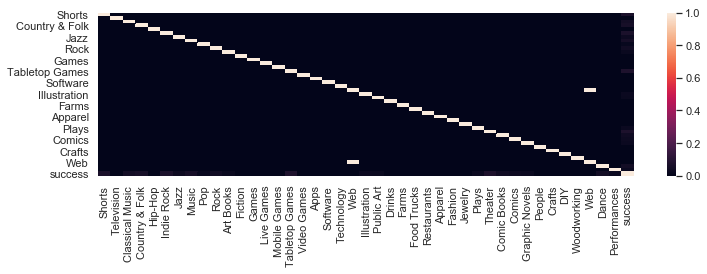

In [ ]:
correlation_heatmap(subcat_list)

#### And once again, there are no problems with multicollinearity here, but there are also no meaningful correlations.

<br><br>
### [<a name='currency_feat'>CURRENCY</a>] I'm just going to test dummies for currency. I won't be using country data, as it's essentially just a less reliable version of currency (see data cleaning).

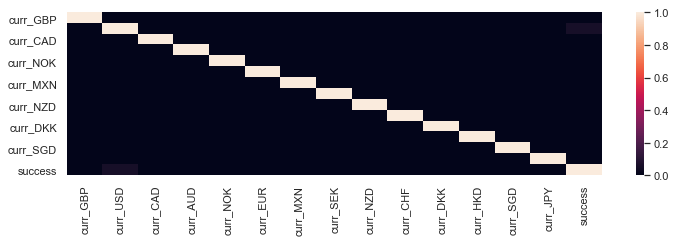

In [ ]:
currency_list = []
df = pd.concat([df, pd.get_dummies(df['currency'], prefix='curr', prefix_sep='_')], axis=1)
[currency_list.append('curr_' + cat) for cat in df['currency'].unique()]

correlation_heatmap(currency_list)

#### None of these currencies correlate with project success.

<hr>
[<a href='#toc'><i>return to top</i></a>]<br><br><br><br><br><br>
# <a name='models'></a>Modeling

In [ ]:
# Define X & y and split the data into training and test sets
X = df[feature_list]
y = df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Create a function for model evaluation
def evaluate_model(model, xtr, ytr, xtst, ytst):
    cross_validation = cross_val_score(model, xtr, ytr, cv=10)
    performance = { 'model':str(model).split('(')[0],
                   'holdout performance':round(model.score(xtst, ytst),2),
                   'cross validation mean':round(cross_validation.mean(),2),
                   'cross validation standard deviation':round(cross_validation.std(),4),
                   'confusion matrix':sklearn.metrics.confusion_matrix(ytst, model.predict(xtst))}
    
    for key in performance:
        print('{}: {}'.format(key,performance[key]))
        
    return performance

#### I'll start by checking my final feature set for correlation with success and for multicollinearity:

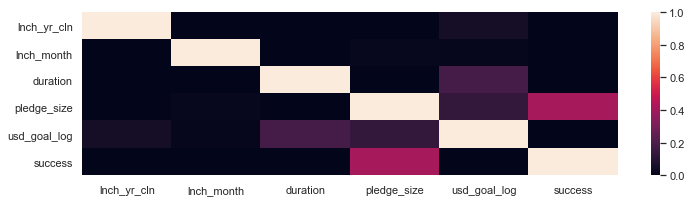

In [ ]:
correlation_heatmap(feature_list)

#### My primary goal of predicting project success with only data available before a campaign's launch isn't tenable - pledge size is the only feature I've been able to derive that's meaningfully correlated with success.

#### I only have one useful feature, so I'm not optimistic about my model's performance. However, I'm going to run it and see how it performs. I'm passing on SVMs because using one would be computationally inefficient given my relatively large number of observations and my relatively slow computer. If logistic regression doesn't give me a satisfactory result, I'll try using a random forest classifier.

In [ ]:
lr = LogisticRegression(C=100)
lr.fit(X_train['pledge_size'].values.reshape(-1, 1), y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
lr_performance = evaluate_model(lr,
                                xtr=X_train['pledge_size'].values.reshape(-1, 1),
                                ytr=y_train,
                                xtst=X_test['pledge_size'].values.reshape(-1, 1),
                                ytst=y_test)

model: LogisticRegression
holdout performance: 0.67
cross validation mean: 0.67
cross validation standard deviation: 0.0021
confusion matrix: [[39588  8502]
 [16228 10939]]


#### This is a slightly better classifier than simply assigning a 0 to every campaign would be, but not much. Note, too, the incredibly weak sensitivity.

#### Let's try a random forest classifier and see if it performs better.

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train['pledge_size'].values.reshape(-1, 1), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
rfc_performance = evaluate_model(rfc,
                                xtr=X_train['pledge_size'].values.reshape(-1, 1),
                                ytr=y_train,
                                xtst=X_test['pledge_size'].values.reshape(-1, 1),
                                ytst=y_test)

model: RandomForestClassifier
holdout performance: 0.72
cross validation mean: 0.72
cross validation standard deviation: 0.0026
confusion matrix: [[39543  8547]
 [12386 14781]]


#### My random forest classifier performs 5% more accurately on the holdout than my logistic regression model does, with a notable gain in sensitivity. I might be able to get an additional bump on the logistic regression model if I tinker with its hyperparameters a little bit, but I'm not sure that that would be a fruitful use of time at this point – it looks to me like I'm starting to bump up against the limits of this dataset's predictive power. For now, I'll move on and consider my next steps.

<hr>
[<a href='#toc'><i>return to top</i></a>]<br><br><br><br><br><br>
# <a name='conclusion'></a>Conclusion & Next Steps

### Issues with the model
Despite my best efforts with feature engineering, I believe I've hit the predictive limits of this dataset. Logistic regression (~67% holdout accuracy) didn't perform substantially better than assigning failure to every project would have (~64% accuracy), and, although random forest performed reasonably well (~72% holdout accuracy), it's still contingent upon the use of average donation size – a feature that's only truly available in _finished_ campaigns. Given this fact, it's distinctly possible that all of the predictive power in the random forest model would disappear if it were used to predict in-progress campaigns instead of finished campaigns. Truly validating this model would require testing it on live campaigns over time, then tracking the outcomes of those campaigns.

### Next steps
All of that said, there is potentially useful, publicly available data for Kickstarter projects that is not available in the dataset I used – it’s ripe to be harvested by a better scraper and deployed in a second crack at this model.
* Reward tier data, which could be used to examine number of reward tiers, the cost of tiers, common keywords inside tiers, etc.
* Demographic information about donors, such as location by city and country.
* Project description, which could provide a wealth of information: number of images used, length, keywords, presence or absence of stretch goals for the project, etc.
* Project updates, which could be used as a proxy for the project starter’s active engagement with the campaign.

<hr>
[<a href='#toc'><i>return to top</i></a>]